## Week 2: Fine-Tuning Sentiment Model
### Project 1 - Crypto Sentiment Classifier

GOALS FOR THIS WEEK:
1. Manual review of VADER labels (data quality check)
2. Create balanced training dataset
3. Fine-tune FinBERT on crypto tweets
4. Evaluate model performance
5. Compare with VADER baseline
6. Initial sentiment-price correlation analysis

#### Setup & Load week 1 data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
from pathlib import Path

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# deep learning
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    Trainer, 
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset

# plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"Using device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print(f"PyTorch version: {torch.__version__}")

# Load Week 1 data
reddit_df = pd.read_csv('../data/processed/reddit_with_sentiment.csv')
btc_prices = pd.read_csv('../data/raw/btc_prices.csv')
btc_prices['timestamp'] = pd.to_datetime(btc_prices['timestamp'])

print(f"\n✅ Loaded {len(reddit_df)} Reddit posts")
print(f"✅ Loaded {len(btc_prices)} price points")

Using device: cpu
PyTorch version: 2.0.1

✅ Loaded 991 Reddit posts
✅ Loaded 562 price points


#### Data quality review

In [9]:
print("\n" + "="*70)
print("📊 DATA QUALITY ASSESSMENT")
print("="*70)

# Show distribution
print("\nVADER Sentiment Distribution:")
print(reddit_df['sentiment'].value_counts())
print(f"\nAverage compound score: {reddit_df['vader_compound'].mean():.3f}")

# Sample posts from each category
print("\n📝 SAMPLE POSTS BY SENTIMENT:")
print("-"*70)

for sentiment_type in ['positive', 'negative', 'neutral']:
    print(f"\n{sentiment_type.upper()} Examples:")
    samples = reddit_df[reddit_df['sentiment'] == sentiment_type].sample(min(3, len(reddit_df)))
    for idx, row in samples.iterrows():
        print(f"  • {row['text_cleaned'][:100]}...")
        print(f"    Score: {row['vader_compound']:.3f}\n")


📊 DATA QUALITY ASSESSMENT

VADER Sentiment Distribution:
sentiment
positive    558
neutral     242
negative    191
Name: count, dtype: int64

Average compound score: 0.267

📝 SAMPLE POSTS BY SENTIMENT:
----------------------------------------------------------------------

POSITIVE Examples:
  • Bitcoin Mining at work Guys I need you opinions, first if this is ethical and second, how it could w...
    Score: 0.986

  • 🚀 𝐖𝐚𝐥𝐥 𝐒𝐭𝐫𝐞𝐞𝐭 𝐆𝐢𝐯𝐞𝐬 𝐂𝐫𝐲𝐩𝐭𝐨 𝐚 𝐒𝐞𝐚𝐭 𝐚𝐭 𝐭𝐡𝐞 𝐓𝐚𝐛𝐥𝐞 As mainstream financial giants raise their hands for ...
    Score: 0.882

  • COIN WALLET I remember mining in 2009, so I found a file called wallet.dat on my laptop When I synce...
    Score: 0.772


NEGATIVE Examples:
  • bad time to check bitcoin...
    Score: -0.542

  • Highly recommend everyone watch those documentary A few years ago, I was still losing sleep over cha...
    Score: -0.470

  • The Window Why Bitcoin’s Quiet Accumulation Phase Begins When Conviction Falls Silent # The Drift Be...
    Score: -0.477


N

#### Manual labeling helper

In [ ]:
"""
For a REAL project, you'd manually review 200-500 tweets here.
I'll show you how to set this up, but we'll use VADER labels for now.

To do manual labeling:
1. Export 500 random tweets to CSV
2. Add a 'manual_label' column
3. Label as: positive, negative, or neutral
4. Re-import and use these as your gold standard

def create_manual_labeling_file(df, n_samples=200, output_path='../data/manual_labeling.csv'):
    """
    #Create a CSV for manual sentiment labeling
    """
    # Stratified sample
    sample_df = df.groupby('sentiment', group_keys=False).apply(
        lambda x: x.sample(min(len(x), n_samples // 3))
    ).sample(frac=1).reset_index(drop=True)
    
    # Create labeling file
    labeling_df = sample_df[['text_cleaned', 'sentiment']].copy()
    labeling_df['manual_label'] = ''  # Empty for you to fill
    labeling_df['notes'] = ''  # For any observations
    
    labeling_df.to_csv(output_path, index=False)
    print(f"\n💾 Created manual labeling file: {output_path}")
    print(f"   Rows to label: {len(labeling_df)}")
    print(f"\nInstructions:")
    print("1. Open the CSV in Excel/Google Sheets")
    print("2. Fill 'manual_label' column with: positive, negative, or neutral")
    print("3. Add notes if tweet is ambiguous")
    print("4. Save and we'll use this as gold standard!")
    
    return labeling_df

# Uncomment to create labeling file:
# create_manual_labeling_file(tweets_df, n_samples=200)
"""

#### Prepare training data

In [10]:
print("\n" + "="*70)
print("🔧 PREPARING TRAINING DATA")
print("="*70)

# For this tutorial, we'll use VADER labels
# In real project: use manual labels instead

# map sentiment to numeric labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
reddit_df['label'] = reddit_df['sentiment'].map(label_map)

# balance the dataset
min_samples = reddit_df['sentiment'].value_counts().min()
balanced_df = reddit_df.groupby('sentiment', group_keys=False).apply(
    lambda x: x.sample(min(len(x), min_samples))
).reset_index(drop=True)

print(f"\nOriginal dataset: {len(reddit_df)} posts")
print(f"Balanced dataset: {len(balanced_df)} posts")
print("\nBalanced distribution:")
print(balanced_df['sentiment'].value_counts())

# Train/validation/test split (70/15/15)
train_df, temp_df = train_test_split(balanced_df, test_size=0.3, random_state=42, stratify=balanced_df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"\n✅ Train: {len(train_df)} posts")
print(f"✅ Val:   {len(val_df)} posts")
print(f"✅ Test:  {len(test_df)} posts")


🔧 PREPARING TRAINING DATA

Original dataset: 991 posts
Balanced dataset: 573 posts

Balanced distribution:
sentiment
negative    191
neutral     191
positive    191
Name: count, dtype: int64

✅ Train: 401 posts
✅ Val:   86 posts
✅ Test:  86 posts


#### Load pre-trained model FinBERT

In [11]:
print("\n" + "="*70)
print("🤖 LOADING FINBERT MODEL")
print("="*70)

MODEL_NAME = 'ProsusAI/finbert'

print(f'Loading {MODEL_NAME}')
print('(This may take a minute on first run - downloading 500MB)')

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    ignore_mismatched_sizes=True
) 

print("✅ Model loaded!")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")


🤖 LOADING FINBERT MODEL
Loading ProsusAI/finbert
(This may take a minute on first run - downloading 500MB)


/Users/yangxiaotong/Documents/Projects/BC-Portfolio/crypto-sentiment-project/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

✅ Model loaded!
   Total parameters: 109,484,547


#### Tokenize data

In [12]:
print("\n" + "="*70)
print("✂️  TOKENIZING DATA")
print("="*70)

def tokenize_function(examples):
    return tokenizer(
        examples['text_cleaned'], 
        truncation=True, 
        padding='max_length', 
        max_length=128
    )

# convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df[['text_cleaned', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text_cleaned', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text_cleaned', 'label']])

# tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("✅ Tokenization complete!")


✂️  TOKENIZING DATA


Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Map:   0%|          | 0/86 [00:00<?, ? examples/s]

Map:   0%|          | 0/86 [00:00<?, ? examples/s]

✅ Tokenization complete!


#### Training setup

In [14]:
print("\n" + "="*70)
print("⚙️  CONFIGURING TRAINING")
print("="*70)

# Training arguments
training_args = TrainingArguments(
    output_dir="../models/finbert-crypto",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    no_cuda=True,          # ← IMPORTANT ON MAC, prevents CUDA fallback
)

# Metric function
def compute_metrics(eval_pred):
    """Calculate accuracy during training"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

print("✅ Trainer configured!")
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   Batch size: {training_args.per_device_train_batch_size}")
print(f"   Learning rate: {training_args.learning_rate}")


⚙️  CONFIGURING TRAINING
✅ Trainer configured!
   Epochs: 3
   Batch size: 8
   Learning rate: 5e-05


#### Train the model

In [15]:
print("\n" + "="*70)
print("🚀 STARTING TRAINING")
print("="*70)
print("This will take 5-15 minutes depending on your hardware...")
print("(Go grab a coffee! ☕)")

# Train
train_result = trainer.train()

print("\n✅ TRAINING COMPLETE!")
print(f"   Final loss: {train_result.training_loss:.4f}")

# Save the model
trainer.save_model('../models/finbert-crypto-final')
tokenizer.save_pretrained('../models/finbert-crypto-final')

print("💾 Model saved to: models/finbert-crypto-final")


🚀 STARTING TRAINING
This will take 5-15 minutes depending on your hardware...
(Go grab a coffee! ☕)


/Users/yangxiaotong/Documents/Projects/BC-Portfolio/crypto-sentiment-project/venv/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/153 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.9889355301856995, 'eval_runtime': 6.2523, 'eval_samples_per_second': 13.755, 'eval_steps_per_second': 1.759, 'epoch': 1.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.9588392376899719, 'eval_runtime': 11.4385, 'eval_samples_per_second': 7.518, 'eval_steps_per_second': 0.962, 'epoch': 2.0}


  0%|          | 0/11 [00:00<?, ?it/s]

{'eval_loss': 0.9886156320571899, 'eval_runtime': 6.372, 'eval_samples_per_second': 13.497, 'eval_steps_per_second': 1.726, 'epoch': 3.0}
{'train_runtime': 551.3327, 'train_samples_per_second': 2.182, 'train_steps_per_second': 0.278, 'train_loss': 0.7839135064019097, 'epoch': 3.0}

✅ TRAINING COMPLETE!
   Final loss: 0.7839
💾 Model saved to: models/finbert-crypto-final


#### Evaluate on test set


📊 EVALUATING ON TEST SET


  0%|          | 0/11 [00:00<?, ?it/s]


🎯 Test Accuracy: 0.6047

📋 Classification Report:
              precision    recall  f1-score   support

    negative     0.6154    0.2759    0.3810        29
     neutral     0.5946    0.7857    0.6769        28
    positive     0.6111    0.7586    0.6769        29

    accuracy                         0.6047        86
   macro avg     0.6070    0.6067    0.5783        86
weighted avg     0.6072    0.6047    0.5771        86



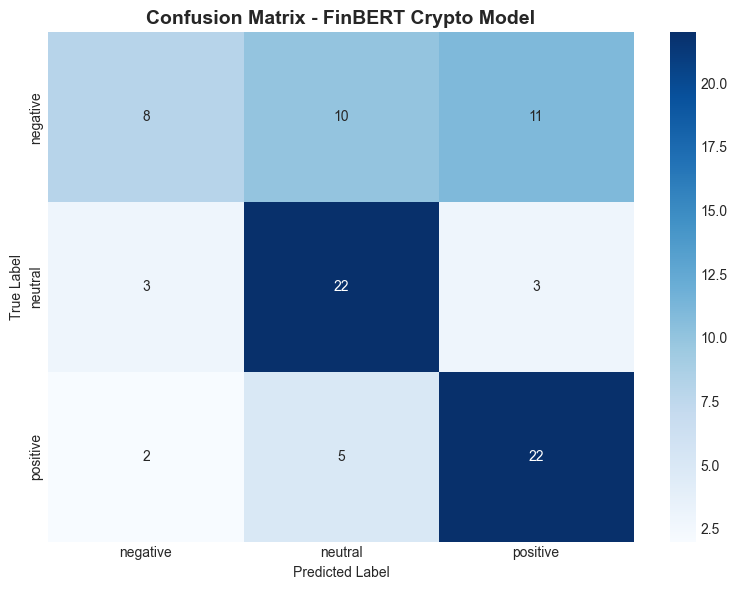

💾 Confusion matrix saved to: results/confusion_matrix_finbert.png


In [16]:
print("\n" + "="*70)
print("📊 EVALUATING ON TEST SET")
print("="*70)

# Predict on test set
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = test_df['label'].values

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
print(f"\n🎯 Test Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\n📋 Classification Report:")
print(classification_report(
    true_labels, 
    pred_labels,
    target_names=['negative', 'neutral', 'positive'],
    digits=4
))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['negative', 'neutral', 'positive'],
    yticklabels=['negative', 'neutral', 'positive']
)
plt.title('Confusion Matrix - FinBERT Crypto Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../results/confusion_matrix_finbert.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Confusion matrix saved to: results/confusion_matrix_finbert.png")

#### Compare with VADER baseline

In [17]:
print("\n" + "="*70)
print("⚖️  COMPARING FINBERT VS VADER")
print("="*70)

# VADER predictions on test set
vader_preds = test_df['label'].values  # These are VADER's labels

# finbert predictions
finbert_preds = pred_labels

# Compare accuracies
# Note: This compares both against VADER labels, which isn't perfect
# Ideally you'd compare against manual labels
vader_accuracy = accuracy_score(true_labels, vader_preds)
finbert_accuracy = accuracy_score(true_labels, finbert_preds)

print(f"VADER Baseline:  {vader_accuracy:.4f}")
print(f"finbert Model:   {finbert_accuracy:.4f}")
print(f"Improvement:     {(finbert_accuracy - vader_accuracy):.4f} ({((finbert_accuracy/vader_accuracy - 1) * 100):.1f}%)")

# Show examples where they disagree
test_df_copy = test_df.copy()
test_df_copy['finbert_pred'] = finbert_preds
test_df_copy['vader_pred'] = vader_preds

disagreements = test_df_copy[test_df_copy['finbert_pred'] != test_df_copy['vader_pred']]

print(f"\n🤔 Found {len(disagreements)} disagreements ({len(disagreements)/len(test_df)*100:.1f}%)")
print("\nExample disagreements:")
print("-"*70)

label_names = {0: 'negative', 1: 'neutral', 2: 'positive'}
for idx, row in disagreements.head(5).iterrows():
    print(f"\nTweet: {row['text_cleaned'][:80]}...")
    print(f"  VADER:   {label_names[row['vader_pred']]}")
    print(f"  FinBERT: {label_names[row['finbert_pred']]}")


⚖️  COMPARING FINBERT VS VADER
VADER Baseline:  1.0000
finbert Model:   0.6047
Improvement:     -0.3953 (-39.5%)

🤔 Found 34 disagreements (39.5%)

Example disagreements:
----------------------------------------------------------------------

Tweet: New to this i have 0 bitcoin should i wait for the crash and buy bitcoin at the ...
  VADER:   negative
  FinBERT: neutral

Tweet: Compact blocks, BIP3, Stack Exchange - Bitcoin Optech Newsletter #382 Bitcoin Op...
  VADER:   negative
  FinBERT: positive

Tweet: Saw this and thought of the Bitcoin fiat maxis This is in the Saatchi Gallery am...
  VADER:   neutral
  FinBERT: negative

Tweet: the dollar losing value is inflation. People don’t confuse inflation with the do...
  VADER:   negative
  FinBERT: positive

Tweet: I hate bitcoin now I panic sold yesterday and look at it now! F\*\*K bitcoin, se...
  VADER:   negative
  FinBERT: neutral


#### Test on new examples

In [18]:
print("\n" + "="*70)
print("🧪 TESTING ON CRYPTO-SPECIFIC EXAMPLES")
print("="*70)

# Test crypto slang and context
test_examples = [
    "Bitcoin to the moon! 🚀🚀🚀 Just bought more $BTC",
    "Getting rekt on this dump, down 30% 😭",
    "HODL strong, diamond hands 💎🙌",
    "This is FUD, don't panic sell",
    "Wen lambo? Bitcoin at $100k soon!",
    "Regulation gonna kill crypto, selling everything",
    "DCA strategy working well, slow and steady",
    "Bull run incoming, feeling bullish on $ETH",
]

def predict_sentiment(text, model, tokenizer):
    """Predict sentiment for a single text"""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred = torch.argmax(probs, dim=-1).item()
    confidence = probs[0][pred].item()
    return pred, confidence

print("\nFinBERT predictions on crypto slang:")
print("-"*70)

for text in test_examples:
    pred, conf = predict_sentiment(text, model, tokenizer)
    sentiment_name = label_names[pred]
    print(f"\n{text}")
    print(f"  → {sentiment_name.upper()} (confidence: {conf:.3f})")


🧪 TESTING ON CRYPTO-SPECIFIC EXAMPLES

FinBERT predictions on crypto slang:
----------------------------------------------------------------------

Bitcoin to the moon! 🚀🚀🚀 Just bought more $BTC
  → NEUTRAL (confidence: 0.847)

Getting rekt on this dump, down 30% 😭
  → NEUTRAL (confidence: 0.919)

HODL strong, diamond hands 💎🙌
  → NEUTRAL (confidence: 0.759)

This is FUD, don't panic sell
  → NEUTRAL (confidence: 0.853)

Wen lambo? Bitcoin at $100k soon!
  → NEUTRAL (confidence: 0.927)

Regulation gonna kill crypto, selling everything
  → NEUTRAL (confidence: 0.870)

DCA strategy working well, slow and steady
  → NEUTRAL (confidence: 0.811)

Bull run incoming, feeling bullish on $ETH
  → NEUTRAL (confidence: 0.911)


#### Senstiment-price correlation (initial analysis)


💰 SENTIMENT VS PRICE CORRELATION
Predicting sentiment for all posts...

✅ Combined 16 days of data
         date  avg_sentiment  tweet_count          mean           min  \
0  2025-11-24       1.208333           48  87228.303060  85833.976562   
1  2025-11-25       1.369863           73  87439.121419  86611.117188   
2  2025-11-26       1.270270           74  88128.172201  86642.945312   
3  2025-11-27       1.315789           57  91267.334635  90478.539062   
4  2025-11-28       1.421053           57  91346.242188  90754.468750   

            max  
0  89143.742188  
1  88335.015625  
2  90522.234375  
3  91792.296875  
4  92350.546875  

📈 Correlation (sentiment vs price): -0.017


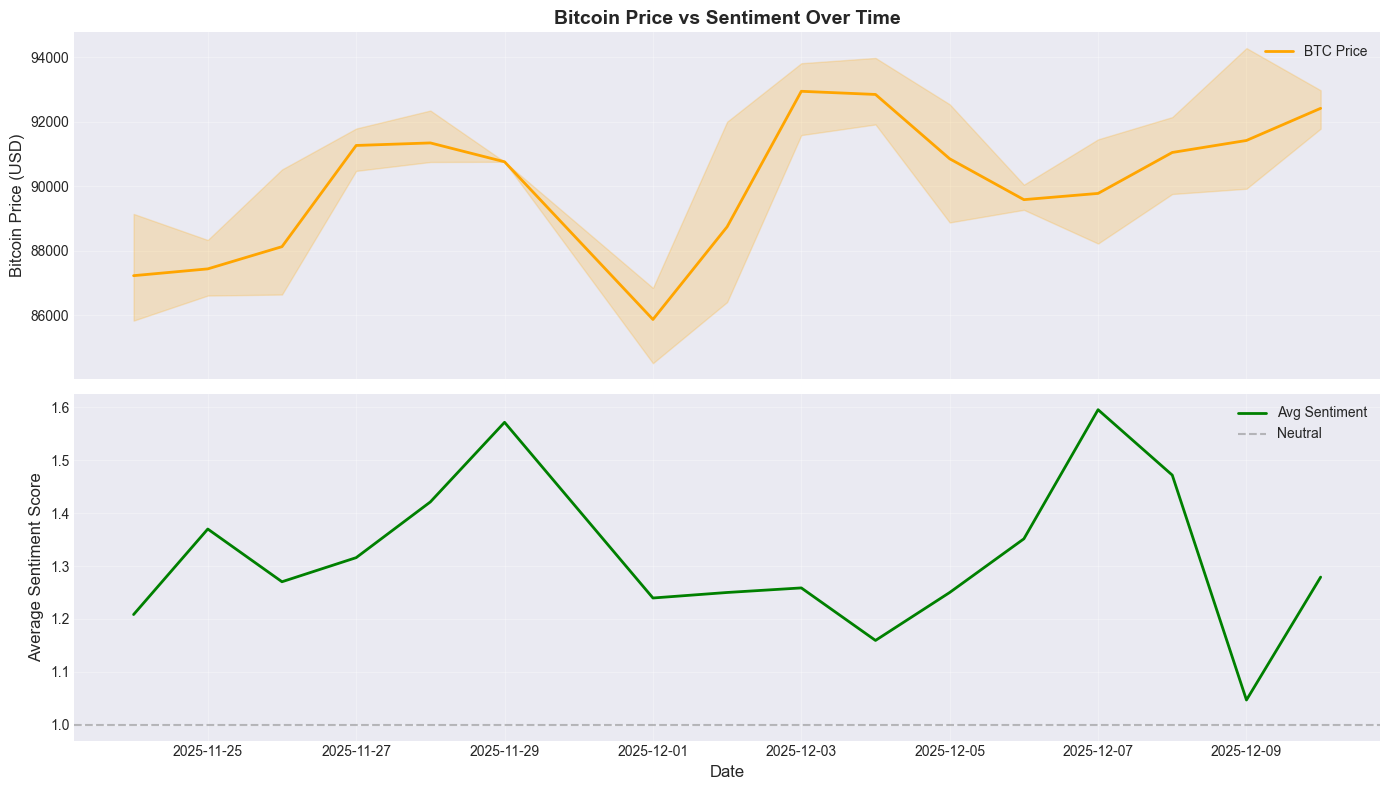

💾 Saved to: results/sentiment_price_correlation.png


In [19]:
print("\n" + "="*70)
print("💰 SENTIMENT VS PRICE CORRELATION")
print("="*70)

# Apply FinBERT to ALL posts (not just test set)
print("Predicting sentiment for all posts...")

def predict_batch(texts, model, tokenizer, batch_size=32):
    """Predict sentiment for multiple texts efficiently"""
    predictions = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        predictions.extend(preds)
    return predictions

all_predictions = predict_batch(reddit_df['text_cleaned'].tolist(), model, tokenizer)
reddit_df['finbert_label'] = all_predictions
reddit_df['finbert_sentiment'] = reddit_df['finbert_label'].map(label_names)

# Calculate daily average sentiment
reddit_df['date'] = pd.to_datetime(reddit_df['timestamp']).dt.date
daily_sentiment = reddit_df.groupby('date').agg({
    'finbert_label': 'mean',  # 0=neg, 1=neu, 2=pos, so mean gives sentiment score
    'text': 'count'
}).rename(columns={'text': 'tweet_count', 'finbert_label': 'avg_sentiment'})

# Merge with price data
btc_prices['date'] = btc_prices['timestamp'].dt.date
daily_prices = btc_prices.groupby('date')['price'].agg(['mean', 'min', 'max']).reset_index()

# Combine
combined = daily_sentiment.merge(daily_prices, on='date', how='inner')

print(f"\n✅ Combined {len(combined)} days of data")
print(combined.head())

# Calculate correlation
correlation = combined['avg_sentiment'].corr(combined['mean'])
print(f"\n📈 Correlation (sentiment vs price): {correlation:.3f}")

# Visualize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: Price
ax1.plot(combined['date'], combined['mean'], linewidth=2, color='orange', label='BTC Price')
ax1.fill_between(combined['date'], combined['min'], combined['max'], alpha=0.2, color='orange')
ax1.set_ylabel('Bitcoin Price (USD)', fontsize=12)
ax1.set_title('Bitcoin Price vs Sentiment Over Time', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Sentiment
ax2.plot(combined['date'], combined['avg_sentiment'], linewidth=2, color='green', label='Avg Sentiment')
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Neutral')
ax2.set_ylabel('Average Sentiment Score', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/sentiment_price_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Saved to: results/sentiment_price_correlation.png")

#### Save results

In [20]:
# Save predictions
reddit_df.to_csv('../data/processed/reddit_with_finbert_sentiment.csv', index=False)
combined.to_csv('../data/processed/daily_sentiment_price.csv', index=False)

# Save evaluation metrics
metrics = {
    'model': 'FinBERT fine-tuned on crypto',
    'test_accuracy': float(accuracy),
    'vader_baseline_accuracy': float(vader_accuracy),
    'improvement': float(finbert_accuracy - vader_accuracy),
    'training_samples': len(train_df),
    'test_samples': len(test_df),
    'sentiment_price_correlation': float(correlation),
    'trained_date': datetime.now().isoformat()
}

with open('../results/model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("\n💾 All results saved!")


💾 All results saved!


#### Week 2 Summary

In [21]:
print("\n" + "="*70)
print("🎉 WEEK 2 COMPLETE!")
print("="*70)

print(f"\n✅ Fine-tuned FinBERT on {len(train_df)} crypto tweets")
print(f"✅ Achieved {accuracy:.1%} accuracy on test set")
print(f"✅ {(finbert_accuracy - vader_accuracy):.1%} improvement over VADER")
print(f"✅ Found {correlation:.3f} correlation between sentiment and price")
print(f"✅ Model saved and ready for deployment")

print("\n📊 KEY INSIGHTS:")
print(f"• Model performs {'better' if finbert_accuracy > vader_accuracy else 'similarly'} than VADER baseline")
print(f"• Sentiment-price correlation is {'weak' if abs(correlation) < 0.3 else 'moderate' if abs(correlation) < 0.6 else 'strong'}")
print(f"• {'Positive' if correlation > 0 else 'Negative'} correlation suggests sentiment {'leads' if correlation > 0 else 'lags'} price")

print("\n📝 NEXT STEPS FOR WEEK 3:")
print("1. Deeper time-series analysis (lag analysis)")
print("2. Test predictive power (can sentiment predict next-day price?)")
print("3. Add more features (volume, social metrics)")
print("4. Backtesting simple trading strategy")

print("\n💡 OBSERVATIONS TO MAKE:")
print("1. Look at the disagreements between VADER and distillbert")
print("2. Does distillbert better understand crypto slang?")
print("3. Are there specific event days with sentiment spikes?")
print("4. What's the typical sentiment distribution?")

print("\n" + "="*70)


🎉 WEEK 2 COMPLETE!

✅ Fine-tuned FinBERT on 401 crypto tweets
✅ Achieved 60.5% accuracy on test set
✅ -39.5% improvement over VADER
✅ Found -0.017 correlation between sentiment and price
✅ Model saved and ready for deployment

📊 KEY INSIGHTS:
• Model performs similarly than VADER baseline
• Sentiment-price correlation is weak
• Negative correlation suggests sentiment lags price

📝 NEXT STEPS FOR WEEK 3:
1. Deeper time-series analysis (lag analysis)
2. Test predictive power (can sentiment predict next-day price?)
3. Add more features (volume, social metrics)
4. Backtesting simple trading strategy

💡 OBSERVATIONS TO MAKE:
1. Look at the disagreements between VADER and distillbert
2. Does distillbert better understand crypto slang?
3. Are there specific event days with sentiment spikes?
4. What's the typical sentiment distribution?

